In [99]:
#import all required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [100]:
#load dataset
titanic_data = pd.read_csv("train.csv")
titanic_data.head() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [101]:
#key statistical features for features/columns
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


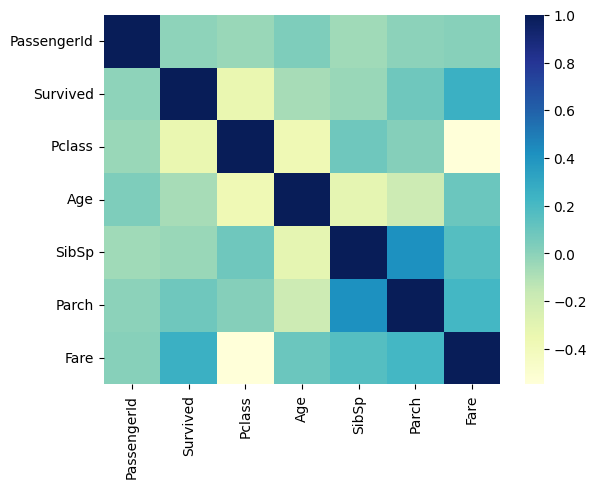

In [102]:
import seaborn as sns

#plotting correlation heatmap to see how features are related to one another as well as survival
sns.heatmap(titanic_data.corr(numeric_only=True), cmap="YlGnBu")
plt.show()

Observations from the Correlation Analysis:

1. **Survival vs. Pclass (Negative Correlation):** There is a notable negative correlation between `Survived` and `Pclass`. As the class number increases (from 1st to 3rd), the probability of survival decreases. This confirms that passengers in higher classes had better access to lifeboats.

2. **Survival vs. Fare (Positive Correlation):** `Fare` shows a positive correlation with `Survived`. Passengers who paid higher fares (likely those in 1st class) had a higher survival rate.

3. **Age vs. Pclass (Negative Correlation):** There is a negative correlation between `Age` and `Pclass`, suggesting that older passengers were more likely to be in the upper classes (1st and 2nd), while younger passengers were more prevalent in 3rd class.

4. **SibSp & Parch (Family Size):** The number of siblings/spouses (`SibSp`) and parents/children (`Parch`) show a positive correlation with each other, which is expected as families often traveled together.

5. **Self-Correlation (Diagonal):** Every feature (Age, Fare, Survived, etc.) has a perfect positive correlation of 1.0 with itself. This creates the distinct dark diagonal line running from the top-left to the bottom-right, serving as the "baseline" for the matrix.

In [103]:
#completing stratified shuffle split (this is like a "Fairness Filter." It ensures that the ratio of the target variable (Survived vs. Deceased) is the same in both our training and testing sets)
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2) #defining the split - only need one pair of (train/test) sets, putting 20% of data into the test set
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]): #making sure ratio of Survived, Pclass, and Sex are identical in both train and test sets (most influential predictors)
    strat_train_set = titanic_data.loc[train_indices] #.loc() - "pulling out" each row data based on each index within train_indices (this is a list)
    strat_test_set = titanic_data.loc[test_indices] #same idea as above line

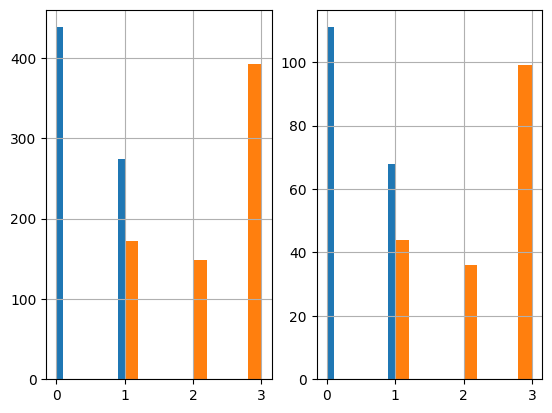

In [104]:
#making sure distribution of Survived and Pclass is equal/symmetrical in both test & train split (verifying "Fairness Filter")
plt.subplot(1,2,1) #grid should have 1 row, 2 columns, where this plot is on panel 1 (left)
strat_train_set["Survived"].hist() #blue = survival, died = 0, survived = 1
strat_train_set["Pclass"].hist() #orange = Pclass

plt.subplot(1,2,2) #grid should have 1 row, 2 columns, where this plot is on panel 2 (right)
strat_test_set["Survived"].hist() 
strat_test_set["Pclass"].hist() 

plt.show()

In [105]:
#checking missing values
strat_train_set.info() #age data is missing values (cabin will most likely be dropped as it is not an influential feature but it also has missing values)

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 294 to 205
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          569 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        162 non-null    object 
 11  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [106]:
#import parents to make our custom tool compatible with Scikit-Learn Pipelines
from sklearn.base import BaseEstimator, TransformerMixin #TransformerMixin allows us to use fit_transform directly, while BaseEstimator will allow us to use get_params() and set_params() (useful for when we want to "tune" the model later)
#import the actual math tool to handle missing values
from sklearn.impute import SimpleImputer 

#create a class to automatically fill missing 'Age' values
class AgeImputer(BaseEstimator, TransformerMixin):
    
    #the 'fit' method is required by Scikit-Learn
    #for this simple imputer, we don't need to learn any complex mathematical relationships, so we just return self (all we are doing is filling missing values, dropping features, and encoding features -> don't need mathematical relationships for this)
    def fit(self, X, y=None): 
        return self
    
    #this is where the data cleaning actually happens
    def transform(self, X):
        #initialize the specialist tool (SimpleImputer) to calculate the average (mean)
        imputer = SimpleImputer(strategy="mean")
        
        #calculate the mean and fill the missing values in the 'Age' column
        #we use [[ ]] to pass 'Age' as a DataFrame (2D) rather than a Series (1D) -> this is so that it is viewed as one column (not just a single list of numbers)
        X["Age"] = imputer.fit_transform(X[["Age"]])
        
        #return the cleaned data so it can pass to the next step in the pipeline
        return X

In [107]:
#feature encoding (for categorical features) 
from sklearn.preprocessing import OneHotEncoder #using one-hot encoding for both gender and embarked

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): #no pre-learning needed for this step
        return self
    #create a matrix of 1s and 0s for the 'Embarked' column
    #.toarray() converts the compressed output into a readable grid
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[["Embarked"]]).toarray() 
        
        #new column names representing the categories
        col_names = ["C", "S", "Q", "N"]
        
        #matrix.T transposes the grid so we can iterate through columns instead of rows
        for i in range(len(matrix.T)):
            #create a new column in our main table for each category
            X[col_names[i]] = matrix.T[i]
        
        matrix = encoder.fit_transform(X[["Sex"]]).toarray()
        col_names = ["Female", "Male"]
        for i in range(len(matrix.T)):
            #create new "Female" and "Male" columns filled with 1s and 0s
            X[col_names[i]] = matrix.T[i] 
        
        return X #return the table with all the new numerical columns added
    
"""
Example of what we should have now with AgeImputer and FeatureEncoder implemented

Pcl | Sex    | Age  | Sib | Emb | C | S | Q | N | Fem | Male
-----------------------------------------------------------
3   | male   | 22.0 | 1   | S   | 0 | 1 | 0 | 0 | 0   | 1
1   | female | 38.0 | 1   | C   | 1 | 0 | 0 | 0 | 1   | 0
3   | female | 26.0 | 0   | S   | 0 | 1 | 0 | 0 | 1   | 0
1   | female | 35.0 | 1   | S   | 0 | 1 | 0 | 0 | 1   | 0

Note: Redundant features need to be removed
"""

'\nExample of what we should have now with AgeImputer and FeatureEncoder implemented\n\nPcl | Sex    | Age  | Sib | Emb | C | S | Q | N | Fem | Male\n-----------------------------------------------------------\n3   | male   | 22.0 | 1   | S   | 0 | 1 | 0 | 0 | 0   | 1\n1   | female | 38.0 | 1   | C   | 1 | 0 | 0 | 0 | 1   | 0\n3   | female | 26.0 | 0   | S   | 0 | 1 | 0 | 0 | 1   | 0\n1   | female | 35.0 | 1   | S   | 0 | 1 | 0 | 0 | 1   | 0\n\nNote: Redundant features need to be removed\n'

In [108]:
#feature dropper class to remove redunant and unnecessary features
class FeatureDropper(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore") #axis=1 -> indicating that this is relevant to the columns (not rows), errors="ignore" (ignoring any errors we get from features that don't exist)
"""
Example of what we should have now with FeatureDropper also implemented

Pclass | Age  | SibSp | Parch | Fare    | C | S | Q | Female | Male
------------------------------------------------------------------
3      | 22.0 | 1     | 0     | 7.2500  | 0 | 1 | 0 | 0      | 1
1      | 38.0 | 1     | 0     | 71.2833 | 1 | 0 | 0 | 1      | 0
3      | 26.0 | 0     | 0     | 7.9250  | 0 | 1 | 0 | 1      | 0
1      | 35.0 | 1     | 0     | 53.1000 | 0 | 1 | 0 | 1      | 0

"""       

'\nExample of what we should have now with FeatureDropper also implemented\n\nPclass | Age  | SibSp | Parch | Fare    | C | S | Q | Female | Male\n------------------------------------------------------------------\n3      | 22.0 | 1     | 0     | 7.2500  | 0 | 1 | 0 | 0      | 1\n1      | 38.0 | 1     | 0     | 71.2833 | 1 | 0 | 0 | 1      | 0\n3      | 26.0 | 0     | 0     | 7.9250  | 0 | 1 | 0 | 1      | 0\n1      | 35.0 | 1     | 0     | 53.1000 | 0 | 1 | 0 | 1      | 0\n\n'

In [109]:
#making the pipeline so that all 3 classes we created can be used together
from sklearn.pipeline import Pipeline

#pipeline here is an object that acts as a "container" to hold and execute our 3 classes in a specific order
pipeline = Pipeline([
                    ("ageimputer", AgeImputer()), #fix the missing values within the age data
                    ("featureencoder", FeatureEncoder()), #convert categorical features into numerical values (one-hot encoding -> turning text into 1s and 0s)
                    ("FeatureDropper", FeatureDropper()) #remove redunant/unnecessary features
])

In [110]:
#this one line drives our data through the entire 'assembly line' (pipeline - above code)
#we pass 'strat_train_set' as the input to be processed
strat_train_set = pipeline.fit_transform(strat_train_set)

In [111]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
294,295,0,3,24.000000,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
882,883,0,3,22.000000,0,0,10.5167,0.0,0.0,1.0,1.0,0.0
476,477,0,2,34.000000,1,0,21.0000,0.0,0.0,1.0,0.0,1.0
221,222,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
265,266,0,2,36.000000,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
560,561,0,3,29.633708,0,0,7.7500,0.0,1.0,0.0,0.0,1.0
439,440,0,2,31.000000,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
634,635,0,3,9.000000,3,2,27.9000,0.0,0.0,1.0,1.0,0.0
344,345,0,2,36.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0


In [112]:
#ensuring all missing values are gone
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 294 to 205
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [113]:
#feature scaling - putting all numbers on the same "playing field"
from sklearn.preprocessing import StandardScaler
X = strat_train_set.drop(["Survived"], axis=1)
y = strat_train_set["Survived"] 
scaler = StandardScaler() #initialize the StandardScaler object that puts all numbers on a similar scale/normalizes it
X_data = scaler.fit_transform(X) #calculate the mean & std dev and transform the features into scaled numbers (using this formula for every number: z = (value - average)/std deviation)
y_data = y.to_numpy() #convert to NumPy as Scikit-Learn prefers arrays over Pandas (just a simple array instead of "labels" and "indices" which is what Pandas gives us), and we don't scale 'y' because 0/1 binary answers don't need normalization

In [114]:
X_data

array([[-0.58618392,  0.82789342, -0.43592653, ...,  0.61848547,
        -0.73561236,  0.73561236],
       [ 1.6863359 ,  0.82789342, -0.59068304, ...,  0.61848547,
         1.35941164, -1.35941164],
       [ 0.11721507, -0.37019624,  0.33785605, ...,  0.61848547,
        -0.73561236,  0.73561236],
       ...,
       [ 0.72785815,  0.82789342, -1.59660038, ...,  0.61848547,
         1.35941164, -1.35941164],
       [-0.39294244, -0.37019624,  0.49261256, ...,  0.61848547,
        -0.73561236,  0.73561236],
       [-0.93015376,  0.82789342, -2.13824818, ...,  0.61848547,
         1.35941164, -1.35941164]], shape=(712, 11))

In [115]:
#model selection - using RandomForest classifier (end decision is just one of two options: Yes/No) because the given data can be easily modeled by multiple decision trees for accuracy and prevent overfitting
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV #GridSearchCV is a "tuner" that automates the process of testing a model across different data subsets to ensure reliable performance

clf = RandomForestClassifier()
#create a 'param_grid' to list the specific settings—such as the number of trees and their maximum depth—that will be evaluated for the "clf"
param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]} #GridSearchCV is going to apply all the combinations based on these parameter values on the classifier model
    
]
#configure 'GridSearchCV' to apply the 'param_grid' to the 'clf'; 'cv=3' indicates that each setting is verified three times on different data rotations for accuracy (e.g. (2 times for training, 1 time for testing))
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data) #execute the process by training the model on all possible parameter combinations and identifying the version that performs best


,estimator,RandomForestClassifier()
,param_grid,"[{'max_depth': [None, 5, ...], 'min_samples_split': [2, 3, ...], 'n_estimators': [10, 100, ...]}]"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,10


In [116]:
#figuring out which param values gives us the best results
final_clf = grid_search.best_estimator_
final_clf

,n_estimators,10
,criterion,'gini'
,max_depth,10
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
#run the entire process with the test set (pre-processing and scoring the model)
#from this we get a good understanding of how well our model is performing (~77.7% - which tells us that our parameters are good)
strat_test_set = pipeline.fit_transform(strat_test_set)
X_test = strat_test_set.drop(["Survived"], axis=1)
y_test = strat_test_set["Survived"]
scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [ ]:
final_clf.score(X_data_test, y_data_test) #checking how good the model's predictions are to the actual data based on the parameters that are currently applied

0.776536312849162

In [ ]:
final_titanic_data = pipeline.fit_transform(titanic_data) #combining test and train data to give our model more examples to work with and find the best params so that it can be applied to test.csv (for the most educated guesses for our final results)
X_final = final_titanic_data.drop(["Survived"], axis=1)
y_final = final_titanic_data["Survived"]
scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()
final_clf.score(X_data_final, y_data_final)

#run GridSearch on all of this
prod_clf = RandomForestClassifier()
#create a 'param_grid' to list the specific settings—such as the number of trees and their maximum depth—that will be evaluated for the "clf"
param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]} #GridSearchCV is going to apply all the combinations based on these parameter values on the classifier model
    
]
#configure 'GridSearchCV' to apply the 'param_grid' to the 'clf'; 'cv=3' indicates that each setting is verified three times on different data rotations for accuracy (e.g. (2 times for training, 1 time for testing))
grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final) #execute the process by training the model on all possible parameter combinations and identifying the version that performs best

,estimator,RandomForestClassifier()
,param_grid,"[{'max_depth': [None, 5, ...], 'min_samples_split': [2, 3, ...], 'n_estimators': [10, 100, ...]}]"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,500


In [120]:
prod_final_clf = grid_search.best_estimator_
prod_final_clf

,n_estimators,500
,criterion,'gini'
,max_depth,5
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [128]:
titanic_test_data = pd.read_csv("test.csv")
final_test_data = pipeline.fit_transform(titanic_test_data)
final_test_data.info() #have one null value (going to use .fillna() method for this)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


In [129]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")
scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)
predictions=prod_final_clf.predict(X_data_final_test)


C:\Users\nitya\AppData\Local\Temp\ipykernel_28352\2875498144.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [130]:
final_df = pd.DataFrame(titanic_test_data["PassengerId"])
final_df["Survived"] = predictions
final_df.to_csv("predictions.csv", index=False)
final_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
